In [1]:
import pandas as pd
from pathlib import Path
import calendar
from sklearn.preprocessing import LabelEncoder

file_path = Path("companies_tweet_data_10y/microsoft.csv")
tweet_df = pd.read_csv(file_path, parse_dates=[['date','time']], infer_datetime_format=True, usecols=['date',"tweet",'time','retweets_count','likes_count'])

# Delete the index label and sort in ascending order
tweet_df.set_index('date_time', inplace=True)
tweet_df.index.name = None
tweet_df.sort_index(axis=0, inplace=True)

# Display sample data
print(len(tweet_df))
display(tweet_df.head())

27082


,tweet,retweets_count,likes_count
2009-09-21 13:19:33,Hi Twittersphere! This is the official page fo...,24,31
2009-09-21 13:19:33,Hi Twittersphere! This is the official page fo...,24,31
2009-09-21 14:40:40,Wanna get get game smart? Check out our tips h...,0,0
2009-09-21 14:40:40,Wanna get get game smart? Check out our tips h...,0,0
2009-09-23 14:33:20,Want to see friends and family in HD? Now you ...,0,0


In [2]:
tweet_df.describe()

,retweets_count,likes_count
count,27082.000000,27082.000000
mean,62.560705,182.784137
std,416.790771,1341.046640
min,0.000000,0.000000
25%,0.000000,1.000000
50%,11.000000,7.000000
75%,51.000000,137.000000
max,22561.000000,100857.000000


In [3]:
# Drop news published after 4pm since it does not affect the closing price of that day
tweet_df = tweet_df.between_time('00:00:00','15:59:00', include_end=False)

# Drop time in the index labels
tweet_df.index = tweet_df.index.date

#tweet_df=tweet_df[(tweet_df['retweets_count']>=tweet_df['retweets_count'].mean()) | (tweet_df['likes_count']>=tweet_df['likes_count'].mean())]

# Display sample data
display(tweet_df.head())

,tweet,retweets_count,likes_count
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31
2009-09-21,Wanna get get game smart? Check out our tips h...,0,0
2009-09-21,Wanna get get game smart? Check out our tips h...,0,0
2009-09-23,Want to see friends and family in HD? Now you ...,0,0


In [4]:
len(tweet_df)

13598

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kn_na\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Create the Facebook Libra sentiment scores DataFrame
tweet_sentiments = []

for tweet in tweet_df["tweet"]:
    try:
        sentiment = analyzer.polarity_scores(tweet) # get sentiment score
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        tweet_sentiments.append({"compound": compound,
                                 "positive": pos,
                                 "negative": neg,
                                 "neutral": neu
                                })
        
    except AttributeError:
        pass
    
# Create DataFrame
sentiments_df = pd.DataFrame(tweet_sentiments, index=tweet_df.index)

# Reorder DataFrame columns
tweet_df = tweet_df.join(sentiments_df)

tweet_df.head()

,tweet,retweets_count,likes_count,compound,negative,neutral,positive
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31,0.0000,0.0,1.000,0.000
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31,0.0000,0.0,1.000,0.000
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31,0.4019,0.0,0.787,0.213
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31,0.4019,0.0,0.787,0.213
2009-09-21,Hi Twittersphere! This is the official page fo...,24,31,0.0000,0.0,1.000,0.000


In [7]:
# calculate the average of compound scores for a day with more than 1 article
import numpy as np
# sentiment_score_df = news_df.groupby(level=0)[['compound']].agg([('avg_sentiment',np.mean), ('article_counts',count)])
sentiment_score_df = tweet_df.groupby(level=0)[['compound']].count()
sentiment_score_df["avg_sentiments"] = tweet_df.groupby(level=0)[['compound']].mean()
#sentiment_score_df.rename(columns= {'compound':"article_counts"}, inplace=True)
sentiment_score_df.drop(columns='compound', inplace=True)
print(len(sentiment_score_df))
display(sentiment_score_df.head())

2458


,avg_sentiments
2009-09-21,0.200950
2009-09-23,0.263350
2009-09-24,0.013567
2009-09-25,0.429650
2009-09-28,-0.526700


In [8]:
import os
import json
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from panel.interact import interact
import panel as pn
pn.extension('plotly')


Bad key "text.kerning_factor" on line 4 in
C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [9]:
load_dotenv()

True

In [10]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [11]:
#start_date = pd.Timestamp("2009-07-15", tz="America/New_York").isoformat()
start_date = pd.Timestamp("2015-01-15", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-15", tz="America/New_York").isoformat()
tickers = ["PFE", "MRNA", "REGN", "MSFT", "SNE"]

# Create the shares DataFrame
timeframe = "1D"

stock_tickers = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

stock_tickerspx = pd.DataFrame()
stock_tickerspx["PFE"] = stock_tickers["PFE"]["close"]
stock_tickerspx["MRNA"] = stock_tickers["MRNA"]["close"]
stock_tickerspx["REGN"] = stock_tickers["REGN"]["close"]
stock_tickerspx["MSFT"] = stock_tickers["MSFT"]["close"]
stock_tickerspx["SNE"] = stock_tickers["SNE"]["close"]

# Drop the time component of the date
stock_tickerspx.index = stock_tickers.index.date
index = stock_tickerspx.index
index.name = "Date"
stock_tickerspx.reset_index(level=0, inplace=True)

# Display sample data
stock_tickerspx.head()

,Date,PFE,MRNA,REGN,MSFT,SNE
0,2015-01-15,32.40,0.7600,397.13,45.48,20.94
1,2015-01-16,32.78,0.7900,408.28,46.22,20.68
2,2015-01-20,33.10,0.7650,421.11,46.39,20.83
3,2015-01-21,32.66,0.7400,418.11,45.91,21.91
4,2015-01-22,32.80,0.7299,420.82,47.12,22.17


In [12]:
stock_tickerspx.set_index(pd.to_datetime(stock_tickerspx['Date'], infer_datetime_format=True), inplace=True, drop=True)
stock_tickerspx.drop(columns=['Date'], inplace=True)
stock_tickerspx.head()

,PFE,MRNA,REGN,MSFT,SNE
Date,,,,,
2015-01-15,32.40,0.7600,397.13,45.48,20.94
2015-01-16,32.78,0.7900,408.28,46.22,20.68
2015-01-20,33.10,0.7650,421.11,46.39,20.83
2015-01-21,32.66,0.7400,418.11,45.91,21.91
2015-01-22,32.80,0.7299,420.82,47.12,22.17


In [13]:
# Creating signals for Pfizer

# Grab just the `date` and `close` from the dataset
# signals_df1 = stock_tickerspx.loc[:,["Date", "PFE"]].copy()
signals_df1 = stock_tickerspx[["MSFT"]].copy()
# Set the short window and long windows
short_window = 20
long_window = 100

# Set the `date` column as the index
#signals_df1 = signals_df1.set_index("Date", drop=True)

# Generate the short and long moving averages (50 and 100 days, respectively)
#signals_df1["SMA20"] = signals_df1.iloc[80:]["PFE"].rolling(window=short_window).mean()
signals_df1["SMA20"] = signals_df1["MSFT"].rolling(window=short_window).mean()
signals_df1["SMA100"] = signals_df1["MSFT"].rolling(window=long_window).mean()
signals_df1["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA20 is under the SMA100, and
# where 1 is when the SMA20 is higher (or crosses over) the SMA100
signals_df1["Signal"][short_window:] = np.where(
    signals_df1["SMA20"][short_window:] > signals_df1["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df1["Entry/Exit"] = signals_df1["Signal"].diff()

signals_df1.head()

,MSFT,SMA20,SMA100,Signal,Entry/Exit
Date,,,,,
2015-01-15,45.48,NaN,NaN,0.0,NaN
2015-01-16,46.22,NaN,NaN,0.0,0.0
2015-01-20,46.39,NaN,NaN,0.0,0.0
2015-01-21,45.91,NaN,NaN,0.0,0.0
2015-01-22,47.12,NaN,NaN,0.0,0.0


In [14]:
#plotting Pfizer signals
def pfizer_plot():
# Visualize exit position relative to close price
    exit = signals_df1[signals_df1['Entry/Exit'] == -1.0]['MSFT'].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Visualize entry position relative to close price
    entry = signals_df1[signals_df1['Entry/Exit'] == 1.0]['MSFT'].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Visualize close price for the investment
    security_close = signals_df1[['MSFT']].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Visualize moving averages
    moving_avgs = signals_df1[['SMA20', 'SMA100']].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Overlay plots
    entry_exit_plot = security_close * moving_avgs * entry * exit
    entry_exit_plot.opts(xaxis=None, title = "Pfizer")
    
    
    return entry_exit_plot

In [15]:
# Set bollinger band window for Pfizer
bollinger_window = 50

# Calculate rolling mean and standard deviation
signals_df1['bollinger_mid_band'] = signals_df1['MSFT'].rolling(window=bollinger_window).mean()
signals_df1['bollinger_std'] = signals_df1['MSFT'].rolling(window=50).std()

# Calculate upper and lowers bands of bollinger band
signals_df1['bollinger_upper_band']  = signals_df1['bollinger_mid_band'] + (signals_df1['bollinger_std'] * 1)
signals_df1['bollinger_lower_band']  = signals_df1['bollinger_mid_band'] - (signals_df1['bollinger_std'] * 1)

# Calculate bollinger band trading signal
signals_df1['bollinger_long'] = np.where(signals_df1['MSFT'] < signals_df1['bollinger_lower_band'], 1.0, 0.0)
signals_df1['bollinger_short'] = np.where(signals_df1['MSFT'] > signals_df1['bollinger_upper_band'], -1.0, 0.0)
signals_df1['bollinger_signal'] = signals_df1['bollinger_long'] + signals_df1['bollinger_short']

In [16]:
signals_df1['daily_return']=signals_df1['MSFT'].pct_change()
signals_df1.head()

,MSFT,SMA20,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,daily_return
Date,,,,,,,,,,,,,
2015-01-15,45.48,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2015-01-16,46.22,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.016271
2015-01-20,46.39,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.003678
2015-01-21,45.91,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.010347
2015-01-22,47.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.026356


In [17]:
#signals_df1['actual_signal'] = signals_df1['daily_return'].apply(lambda x: 1 if x >= 0.01 else (0 if -0.01<x<0.01 else -1))
signals_df1['actual_signal'] = np.where(signals_df1['daily_return'] > 0, 1.0, 0.0)
signals_df1.head()

,MSFT,SMA20,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,daily_return,actual_signal
Date,,,,,,,,,,,,,,
2015-01-15,45.48,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2015-01-16,46.22,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.016271,1.0
2015-01-20,46.39,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.003678,1.0
2015-01-21,45.91,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.010347,0.0
2015-01-22,47.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.026356,1.0


In [18]:
signals_df1=signals_df1.join([sentiment_score_df])

In [19]:
signals_df1=signals_df1[["MSFT","SMA20","daily_return","actual_signal","avg_sentiments"]]
signals_df1.head()

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments
Date,,,,,
2015-01-15,45.48,NaN,NaN,0.0,0.1480
2015-01-16,46.22,NaN,0.016271,1.0,NaN
2015-01-20,46.39,NaN,0.003678,1.0,0.4767
2015-01-21,45.91,NaN,-0.010347,0.0,0.0000
2015-01-22,47.12,NaN,0.026356,1.0,NaN


In [20]:
signals_df1["SMA_shift"]=signals_df1['SMA20'].shift()
signals_df1.head(21)

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-15,45.48,NaN,NaN,0.0,0.148000,NaN
2015-01-16,46.22,NaN,0.016271,1.0,NaN,NaN
2015-01-20,46.39,NaN,0.003678,1.0,0.476700,NaN
2015-01-21,45.91,NaN,-0.010347,0.0,0.000000,NaN
2015-01-22,47.12,NaN,0.026356,1.0,NaN,NaN
2015-01-23,47.18,NaN,0.001273,1.0,NaN,NaN
2015-01-26,47.05,NaN,-0.002755,0.0,NaN,NaN
2015-01-27,42.67,NaN,-0.093092,0.0,NaN,NaN
2015-01-28,41.20,NaN,-0.034450,0.0,NaN,NaN


In [21]:
#signals_df1.dropna(inplace=True, subset=['daily_return','avg_sentiments'])
signals_df1.dropna(inplace=True, subset=['daily_return'])
display(signals_df1.head(21))
len(signals_df1)

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,46.220,NaN,0.016271,1.0,NaN,NaN
2015-01-20,46.390,NaN,0.003678,1.0,0.476700,NaN
2015-01-21,45.910,NaN,-0.010347,0.0,0.000000,NaN
2015-01-22,47.120,NaN,0.026356,1.0,NaN,NaN
2015-01-23,47.180,NaN,0.001273,1.0,NaN,NaN
2015-01-26,47.050,NaN,-0.002755,0.0,NaN,NaN
2015-01-27,42.670,NaN,-0.093092,0.0,NaN,NaN
2015-01-28,41.200,NaN,-0.034450,0.0,NaN,NaN
2015-01-29,42.020,NaN,0.019903,1.0,0.340000,NaN


1511

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [24]:
import tensorflow as tf
import regex as re
import nltk
nltk.download('stopwords')
%matplotlib inline
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kn_na\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Linear Regression

## 1 Feature Data: 20 Days of Stock Price (No Sentiment Score)

In [26]:
# def window_data(df, window, feature_col_number, target_col_number):
#     """
#     This function accepts the column number for the features (X) and the target (y).
#     It chunks the data up with a rolling window of Xt - window to predict Xt.
#     It returns two numpy arrays of X and y.
#     """
#     X = []
#     y = []
#     for i in range(len(df) - window):
#         features = df.iloc[i : (i + window), feature_col_number]
#         target = df.iloc[(i + window), target_col_number]
#         X.append(features)
#         y.append(target)
#     return np.array(X), np.array(y).reshape(-1, 1)

In [27]:
# X1, y1=window_data(signals_df1, 20, 0, 0)
# # Manually splitting the data

# split = int(0.8 * len(X1))

# X1_train = X1[: split]
# X1_test = X1[split:]

# y1_train = y1[: split]
# y1_test = y1[split:]

# print(X1_train.shape)
# print(X1_test.shape)

In [28]:

# X_train = signals_df1.loc[training_start:training_end][['SMA20']]
# y_train = signals_df1['daily_return'][training_start:training_end]
# X_test = signals_df1.loc[testing_start:testing_end][['SMA20']]
# y_test = signals_df1['daily_return'][testing_start:testing_end]

In [29]:
# print(X_train.values.shape)
# print(X_test.values.shape)

In [30]:
# # Importing the MinMaxScaler from sklearn
# from sklearn.preprocessing import MinMaxScaler

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit the MinMaxScaler object with the features data X
# scaler.fit(X1)

# # Scale the features training and testing sets
# X1_train = scaler.transform(X1_train)
# X1_test = scaler.transform(X1_test)

# # Fit the MinMaxScaler object with the target data Y
# scaler.fit(y1)

# # Scale the target training and testing sets
# y1_train = scaler.transform(y1_train)
# y1_test = scaler.transform(y1_test)

In [31]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='loss', patience=3)

## Model 1: Dense Only

In [32]:
# model_1 = Sequential()
# model_1.add(Dense(20, activation='relu', input_shape=(20,)))
# model_1.add(Dropout(0.2))
# model_1.add(Dense(1, activation='linear'))
# model_1.summary()

In [33]:
# model_1.compile(optimizer='adam',
#            	loss='mse',
#            	metrics=['mae'])

In [34]:
# history1=model_1.fit(X1_train, y1_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [35]:
# df1 = pd.DataFrame(history1.history, index=range(1, len(history1.history["loss"]) + 1))

# display(df1.head())

# # Plot the loss
# df1.plot(y="loss")

In [36]:
# # Plot the accuracy
# df1.plot(y="mae")

In [37]:
# predicted1 = model_1.predict(X1_test)
# result1 = pd.DataFrame(predicted1)
# result1.columns = ['predict']
# result1['actual'] = y1_test
# result1.plot()
# plt.show()

#### Use SMA20 instead of 20 days of Stock Prices

In [38]:
signals_df1_copy0 = signals_df1.copy()
signals_df1_copy0 = signals_df1_copy0[['SMA_shift','MSFT','avg_sentiments']]
signals_df1_copy0.dropna(inplace=True, subset=['avg_sentiments','SMA_shift','MSFT'])
X10=signals_df1_copy0[['SMA_shift']].values.reshape(-1,1)
y10=signals_df1_copy0[['MSFT']].values.reshape(-1,1)

split = int(0.8 * len(X10))

X10_train = X10[: split]
X10_test = X10[split:]

y10_train = y10[: split]
y10_test = y10[split:]

print(X10_train.shape)
print(X10_test.shape)

(843, 1)
(211, 1)


In [39]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X10)

# Scale the features training and testing sets
X10_train = scaler.transform(X10_train)
X10_test = scaler.transform(X10_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y10)

# Scale the target training and testing sets
y10_train = scaler.transform(y10_train)
y10_test = scaler.transform(y10_test)

In [40]:
model_10 = Sequential()
model_10.add(Dense(20, activation='relu', input_shape=(1,)))
model_10.add(Dropout(0.2))
model_10.add(Dense(1, activation='linear'))
model_10.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_10.compile(optimizer='adam',
           	loss='mse',
           	metrics=['mae'])

In [42]:
history10=model_10.fit(X10_train, y10_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

,loss,mae
1,0.094326,0.228422
2,0.039005,0.144236
3,0.022914,0.117513
4,0.017964,0.106129
5,0.014747,0.095215


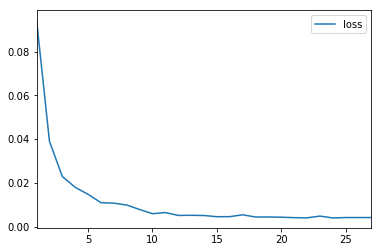

In [43]:
df10 = pd.DataFrame(history10.history, index=range(1, len(history10.history["loss"]) + 1))

display(df10.head())

# Plot the loss
df10.plot(y="loss")

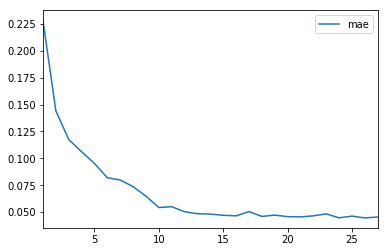

In [44]:
# Plot the accuracy
df10.plot(y="mae")

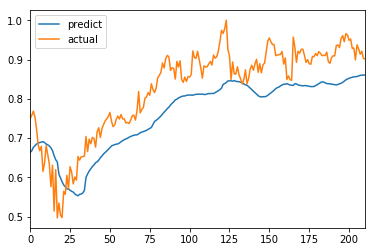

In [45]:
predicted10 = model_10.predict(X10_test)
result10 = pd.DataFrame(predicted10)
result10.columns = ['predict_SMA20']
result10['actual'] = y10_test
result10.plot()
plt.show()

## Model 2: LSTM

In [46]:
# model_2 = Sequential()
# model_2.add(LSTM(20,
#              #dropout=0.2,
#              #recurrent_dropout=0.2,
#              return_sequences=True,
#              input_shape=(20,1)))
# model_2.add(Dropout(0.2))
# # model_2.add(Dense(5, activation='relu'))
# # model_2.add(Dropout(0.2))
# model_2.add(LSTM(units=20, return_sequences=True))
# model_2.add(Dropout(0.2))

# model_2.add(LSTM(units=20))
# model_2.add(Dropout(0.2))

# model_2.add(Dense(1, activation='linear'))
# model_2.summary()
# model_2.compile(optimizer='adam',
#            loss='mse',
#            metrics=['mae'])

In [47]:
# X1_train_res=X1_train[:,:,np.newaxis]
# X1_train_res.shape

In [48]:
# history2=model_2.fit(X1_train_res, y1_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [49]:
# df2 = pd.DataFrame(history2.history, index=range(1, len(history2.history["loss"]) + 1))

# display(df2.head())

# # Plot the loss
# df2.plot(y="loss")

In [50]:
# # Plot the accuracy
# df2.plot(y="mae")

In [51]:
# predicted2 = model_2.predict(X1_test[:,:,np.newaxis])
# result2 = pd.DataFrame(predicted2)
# result2.columns = ['predict']
# result2['actual'] = y1_test
# result2.plot()
# plt.show()

In [52]:
model_20 = Sequential()
model_20.add(LSTM(20,
             #dropout=0.2,
             #recurrent_dropout=0.2,
             return_sequences=True,
             input_shape=(1,1)))
model_20.add(Dropout(0.2))
# model_2.add(Dense(5, activation='relu'))
# model_2.add(Dropout(0.2))
model_20.add(LSTM(units=20, return_sequences=True))
model_20.add(Dropout(0.2))

model_20.add(LSTM(units=20))
model_20.add(Dropout(0.2))

model_20.add(Dense(1, activation='linear'))
model_20.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 20)             1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 20)             3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [53]:
model_20.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [54]:
X10_train_res=X10_train[:,:,np.newaxis]
X10_train_res.shape

(843, 1, 1)

In [55]:
history20=model_20.fit(X10_train_res, y10_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

,loss,mae
1,0.066611,0.197439
2,0.030606,0.144690
3,0.022628,0.128144
4,0.012950,0.095238
5,0.005217,0.056166


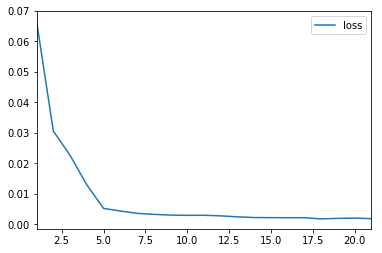

In [56]:
df20 = pd.DataFrame(history20.history, index=range(1, len(history20.history["loss"]) + 1))

display(df20.head())

# Plot the loss
df20.plot(y="loss")

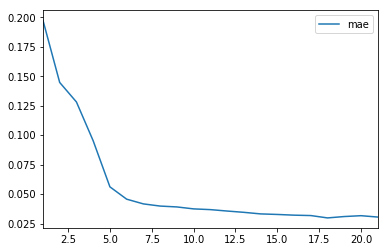

In [57]:
# Plot the accuracy
df20.plot(y="mae")

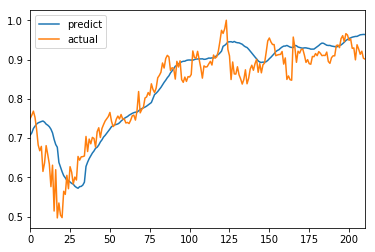

In [58]:
predicted20 = model_20.predict(X10_test[:,:,np.newaxis])
result20 = pd.DataFrame(predicted20)
result20.columns = ['predict_SMA20']
result20['actual'] = y10_test
result20.plot()
plt.show()

## 2 Features: 20 Days of Stock Prices and Sentiment Score

In [59]:
signals_df1.head(20)

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,46.22,NaN,0.016271,1.0,NaN,NaN
2015-01-20,46.39,NaN,0.003678,1.0,0.476700,NaN
2015-01-21,45.91,NaN,-0.010347,0.0,0.000000,NaN
2015-01-22,47.12,NaN,0.026356,1.0,NaN,NaN
2015-01-23,47.18,NaN,0.001273,1.0,NaN,NaN
2015-01-26,47.05,NaN,-0.002755,0.0,NaN,NaN
2015-01-27,42.67,NaN,-0.093092,0.0,NaN,NaN
2015-01-28,41.20,NaN,-0.034450,0.0,NaN,NaN
2015-01-29,42.02,NaN,0.019903,1.0,0.340000,NaN


In [60]:
signals_df1_copy = signals_df1.copy()
signals_df1_copy.dropna(inplace=True)
X2= signals_df1_copy[['SMA_shift','avg_sentiments']]
y2=signals_df1_copy['MSFT']

split = int(0.8 * len(X2))

X2_train = X2[: split]
X2_test = X2[split:]

y2_train = y2[: split]
y2_test = y2[split:]

print(len(X2_train))
display(X2_train.head())
print(len(X2_test))
display(X2_test.head())

843


,SMA_shift,avg_sentiments
Date,,
2015-02-13,43.58200,0.670500
2015-02-17,43.50100,0.585380
2015-02-18,43.36875,0.778950
2015-02-19,43.22575,0.664933
2015-02-20,43.10575,0.670500


211


,SMA_shift,avg_sentiments
Date,,
2020-02-13,172.9625,0.42150
2020-02-14,173.9860,0.04019
2020-02-19,175.9515,0.37780
2020-02-20,176.9910,0.00000
2020-02-21,177.9230,0.44720


In [61]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X2)

# Scale the features training and testing sets
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(np.array(y2).reshape(-1, 1))

# Scale the target training and testing sets
y2_train = scaler.transform(np.array(y2_train).reshape(-1, 1))
y2_test = scaler.transform(np.array(y2_test).reshape(-1, 1))

In [62]:
print(X2_train.shape)
print(y2_train.shape)

(843, 2)
(843, 1)


## Model 3: Dense Only

In [63]:
model_3 = Sequential()
model_3.add(Dense(20, activation='relu', input_shape=(2,)))
model_3.add(Dropout(0.2))
model_3.add(Dense(1, activation='linear'))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                60        
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_3.compile(optimizer='adam',
           	loss='mse',
           	metrics=['mae'])

In [65]:
history3=model_3.fit(X2_train, y2_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

,loss,mae
1,0.038650,0.154466
2,0.018402,0.105407
3,0.013642,0.088794
4,0.010160,0.076194
5,0.008745,0.069938


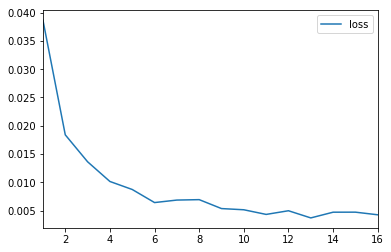

In [66]:
df3 = pd.DataFrame(history3.history, index=range(1, len(history3.history["loss"]) + 1))

display(df3.head())

# Plot the loss
df3.plot(y="loss")

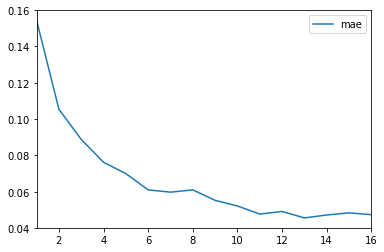

In [67]:
# Plot the accuracy
df3.plot(y="mae")

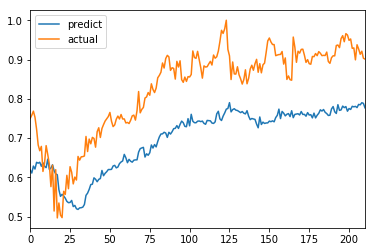

In [68]:
predicted3 = model_3.predict(X2_test)
result3 = pd.DataFrame(predicted3)
result3.columns = ['predict_2features']
result3['actual'] = y2_test
result3.plot()
plt.show()

## Model 4: LSTM

In [69]:
model_4 = Sequential()
model_4.add(LSTM(20,
             #dropout=0.2,
             #recurrent_dropout=0.2,
             return_sequences=True,
             input_shape=(2,1)))
model_4.add(Dropout(0.2))
# model_2.add(Dense(5, activation='relu'))
# model_2.add(Dropout(0.2))
model_4.add(LSTM(units=20, return_sequences=True))
model_4.add(Dropout(0.2))

model_4.add(LSTM(units=20))
model_4.add(Dropout(0.2))

model_4.add(Dense(1, activation='linear'))
model_4.summary()
model_4.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 2, 20)             1760      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 20)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 20)             3280      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [70]:
X2_train_res=X2_train[:,:,np.newaxis]
X2_train_res.shape

(843, 2, 1)

In [71]:
history4=model_4.fit(X2_train_res, y2_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

,loss,mae
1,0.054036,0.179371
2,0.027151,0.140874
3,0.019103,0.117659
4,0.008841,0.075514
5,0.005454,0.055214


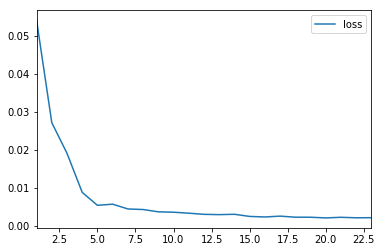

In [72]:
df4 = pd.DataFrame(history4.history, index=range(1, len(history4.history["loss"]) + 1))

display(df4.head())

# Plot the loss
df4.plot(y="loss")

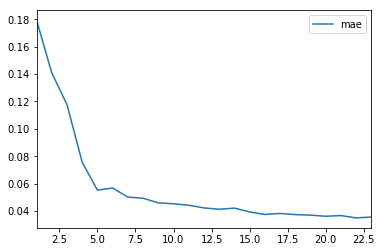

In [73]:
# Plot the accuracy
df4.plot(y="mae")

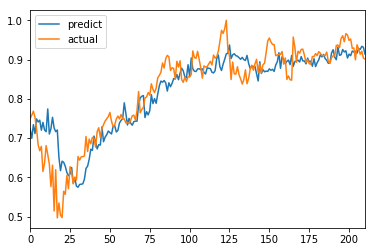

In [74]:
predicted4 = model_4.predict(X2_test[:,:,np.newaxis])
result4 = pd.DataFrame(predicted4)
result4.columns = ['predict_2features']
result4['actual'] = y2_test
result4.plot()
plt.show()

## Incorporate Visualizations

In [116]:
result_joined_dense=result10.merge(result3, on='actual')
result_joined_dense.head()

,predict_SMA20,actual,predict_2features
0,0.660130,0.748598,0.659846
1,0.662497,0.748703,0.681668
2,0.664257,0.738483,0.668024
3,0.668094,0.736963,0.657951
4,0.669804,0.745296,0.655628


In [122]:
result_joined_dense.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [120]:
result_joined_lstm=result20.merge(result4, on='actual')
result_joined_lstm.head()

,predict_SMA20,actual,predict_2features
0,0.751963,0.748598,0.727581
1,0.755534,0.748703,0.787570
2,0.758189,0.738483,0.742650
3,0.763979,0.736963,0.716508
4,0.766558,0.745296,0.711099


In [123]:
result_joined_lstm.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# Logistic Regression

## 1 Feature Data: only 20 Days of Stock Price

In [75]:
signals_df1.head()

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,46.22,NaN,0.016271,1.0,NaN,NaN
2015-01-20,46.39,NaN,0.003678,1.0,0.4767,NaN
2015-01-21,45.91,NaN,-0.010347,0.0,0.0000,NaN
2015-01-22,47.12,NaN,0.026356,1.0,NaN,NaN
2015-01-23,47.18,NaN,0.001273,1.0,NaN,NaN


In [76]:
# X3, y3=window_data(signals_df1, 20, 0, 3)
# # Manually splitting the data

# split = int(0.8 * len(X3))

# X3_train = X3[: split]
# X3_test = X3[split:]

# y3_train = y3[: split]
# y3_test = y3[split:]

# print(X3_train.shape)
# print(X3_test.shape)
# print(y3)

In [77]:
signals_df1_copy2 = signals_df1.copy()
signals_df1_copy2 = signals_df1_copy2[['SMA_shift','actual_signal','avg_sentiments']]
signals_df1_copy2.dropna(inplace=True, subset=['avg_sentiments','SMA_shift','actual_signal'])
X30=signals_df1_copy2[['SMA_shift']].values.reshape(-1,1)
y30=signals_df1_copy2[['actual_signal']].values.reshape(-1,1)

split = int(0.8 * len(X30))

X30_train = X30[: split]
X30_test = X30[split:]

y30_train = y30[: split]
y30_test = y30[split:]

print(X30_train.shape)
print(X30_test.shape)

(843, 1)
(211, 1)


In [78]:
from collections import Counter
Counter(signals_df1.actual_signal)

Counter({1.0: 826, 0.0: 685})

In [79]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X30)

# Scale the features training and testing sets
X30_train = scaler.transform(X30_train)
X30_test = scaler.transform(X30_test)

# # Fit the MinMaxScaler object with the target data Y
# scaler.fit(y3)

# # Scale the target training and testing sets
# y3_train = scaler.transform(y3_train)
# y3_test = scaler.transform(y3_test)

## Model 5: Dense Only

In [80]:
model_5 = Sequential()
model_5.add(Dense(20, activation='relu', input_shape=(1,)))
model_5.add(Dropout(0.2))
model_5.add(Dense(1, activation='sigmoid'))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                40        
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [81]:
model_5.compile(optimizer='adam',
           	loss='binary_crossentropy',
           	metrics=['acc'])

In [82]:
history5=model_5.fit(X30_train, y30_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [83]:
model_5.evaluate(X30_test, y30_test)

7/7 [==============================] - 0s 721us/step - loss: 0.7006 - acc: 0.5261


[0.7005568146705627, 0.5260663628578186]

## Model 6: LSTM

In [84]:
model_6 = Sequential()
model_6.add(LSTM(20,
             #dropout=0.2,
             #recurrent_dropout=0.2,
             return_sequences=True,
             input_shape=(1,1)))
model_6.add(Dropout(0.2))
# model_2.add(Dense(5, activation='relu'))
# model_2.add(Dropout(0.2))
model_6.add(LSTM(units=20, return_sequences=True))
model_6.add(Dropout(0.2))

model_6.add(LSTM(units=20))
model_6.add(Dropout(0.2))

model_6.add(Dense(1, activation='sigmoid'))
model_6.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 20)             1760      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 20)             3280      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 20)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [85]:
model_6.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['acc'])

In [86]:
X30_train_res=X30_train[:,:,np.newaxis]
X30_train_res.shape

(843, 1, 1)

In [87]:
history6=model_6.fit(X30_train_res, y30_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [88]:
model_6.evaluate(X30_test[:,:,np.newaxis], y30_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.5261


[0.693120539188385, 0.5260663628578186]

## 2 Features: 20 Days of Stock Prices and Sentiment Score

In [89]:
signals_df1_copy3 = signals_df1.copy()
signals_df1_copy3 = signals_df1_copy3[['SMA_shift','actual_signal','avg_sentiments']]
signals_df1_copy3.dropna(inplace=True, subset=['avg_sentiments','SMA_shift','actual_signal'])
X40=signals_df1_copy3[['SMA_shift','avg_sentiments']]
y40=signals_df1_copy3[['actual_signal']]

split = int(0.8 * len(X40))

X40_train = X40[: split]
X40_test = X40[split:]

y40_train = y40[: split]
y40_test = y40[split:]

print(X40_train.shape)
print(X40_test.shape)

(843, 2)
(211, 2)


In [90]:
# signals_df1_copy2 = signals_df1.copy()
# signals_df1_copy2.dropna(inplace=True)
# X4= signals_df1_copy[['SMA_shift','avg_sentiments']]
# y4=signals_df1_copy['actual_signal']

# split = int(0.8 * len(X4))

# X4_train = X4[: split]
# X4_test = X4[split:]

# y4_train = y4[: split]
# y4_test = y4[split:]

# print(len(X4_train))
# display(X4_train.head())
# print(len(X4_test))
# display(X4_test.head())

In [91]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X40)

# Scale the features training and testing sets
X40_train = scaler.transform(X40_train)
X40_test = scaler.transform(X40_test)

# Fit the MinMaxScaler object with the target data Y
# scaler.fit(y4)

# # Scale the target training and testing sets
# y4_train = scaler.transform(y4_train)
# y4_test = scaler.transform(y4_test)

## Model 7: Dense Only

In [92]:
model_7 = Sequential()
model_7.add(Dense(20, activation='relu', input_shape=(2,)))
model_7.add(Dropout(0.2))
model_7.add(Dense(1, activation='sigmoid'))
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                60        
_________________________________________________________________
dropout_12 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [93]:
model_7.compile(optimizer='adam',
           	loss='binary_crossentropy',
           	metrics=['acc'])

In [94]:
history7=model_7.fit(X40_train, y40_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [95]:
model_7.evaluate(X40_test, y40_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.6935 - acc: 0.5261


[0.6934555768966675, 0.5260663628578186]

## Model 8: LSTM

In [96]:
model_8 = Sequential()
model_8.add(LSTM(20,
             #dropout=0.2,
             #recurrent_dropout=0.2,
             return_sequences=True,
             input_shape=(2,1)))
model_8.add(Dropout(0.2))
# model_2.add(Dense(5, activation='relu'))
# model_2.add(Dropout(0.2))
model_8.add(LSTM(units=20, return_sequences=True))
model_8.add(Dropout(0.2))

model_8.add(LSTM(units=20))
model_8.add(Dropout(0.2))

model_8.add(Dense(1, activation='sigmoid'))
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 2, 20)             1760      
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 20)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 2, 20)             3280      
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 20)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [97]:
model_8.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['acc'])

In [98]:
X40_train_res=X40_train[:,:,np.newaxis]
X40_train_res.shape

(843, 2, 1)

In [99]:
history8=model_8.fit(X40_train_res, y40_train, batch_size=20, epochs=500, verbose=0, callbacks=[earlystopping])

In [100]:
model_8.evaluate(X40_test[:,:,np.newaxis], y40_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.6940 - acc: 0.5261


[0.6940008997917175, 0.5260663628578186]

In [101]:
# train_set1 = train_set[train_set['t']==1]
# train_set2 = train_set[train_set['t']==0]

# fig = plt.figure(figsize=(7, 7))
# subplot = fig.add_subplot(1, 1, 1)
# subplot.set_ylim([-15, 15])
# subplot.set_xlim([-15, 15])
# subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
# subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

# locations = [[x1, x2] for x2 in np.linspace(-15, 15, 100) 
#                       for x1 in np.linspace(-15, 15, 100)]
# p_vals = model.predict(np.array(locations)).reshape((100, 100))
# subplot.imshow(p_vals, origin='lower', extent=(-15, 15, -15, 15),
#                cmap=plt.cm.gray_r, alpha=0.5)